# Trabalho Prático Integrador 3

### Enunciado

Neste Trabalho Prático os alunos devem escolher com qual conjunto de dados trabalhar para resolver um problema de classificação com alguns dos modelos apresentados no curso.

Objetivos:
* Selecionar os dados para modelar. Justificar a escolha.
* Treinar pelo menos três modelos de classificação diferentes nesses dados.
* Avaliar o desempenho dos modelos e comparar vantagens e desvantagens de cada um.
* Determinar a importância dos recursos incluídos na previsão. Interpretar.

### Importando as bibliotecas

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

### Importando a base de dados

In [14]:
Data = pd.read_csv('Data/water_potability.csv')
Data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [15]:
Data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Renomeando as colunas para o Português

In [16]:
Data = Data.rename(columns={'Hardness'        :  'Dureza',
                     'Solids'          :  'Sólidos',
                     'Chloramines'     :  'Cloraminas',
                     'Sulfate'         :  'Sulfato',
                     'Conductivity'    :  'Condutividade',
                     'Organic_carbon'  :  'Carbono organico',
                     'Trihalomethanes' :  'Trialometanos',
                     'Turbidity'       :  'Turbidez',
                     'Potability'      :  'Potabilidade'})

Data.head()

,ph,Dureza,Sólidos,Cloraminas,Sulfato,Condutividade,Carbono organico,Trialometanos,Turbidez,Potabilidade
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Verificando se há valor nulo

In [17]:
Data.isnull().sum()

ph                  491
Dureza                0
Sólidos               0
Cloraminas            0
Sulfato             781
Condutividade         0
Carbono organico      0
Trialometanos       162
Turbidez              0
Potabilidade          0
dtype: int64

In [18]:
(Data.isnull().sum()/len(Data))*100

#porcentagem de NaN

ph                  14.987790
Dureza               0.000000
Sólidos              0.000000
Cloraminas           0.000000
Sulfato             23.840049
Condutividade        0.000000
Carbono organico     0.000000
Trialometanos        4.945055
Turbidez             0.000000
Potabilidade         0.000000
dtype: float64

### Limpando o dataset

* No Trialometano, a gente vai substituir os NaN pela média, pois de acordo com a Agência de Proteção Ambiental (EPA) o valor máximo de Trialometanos na água é de 100ug/L e 66.4mg/l está dentro do valor permitido. (<http://sanepar.com.br/sanepar/sanare/v17/TRIHALOMETANOS.htm>)

In [19]:
print(Data.Trialometanos.describe())
print('-------------------------------------')
print('valor da mediana:', Data.Trialometanos.median())

count    3114.000000
mean       66.396293
std        16.175008
min         0.738000
25%        55.844536
50%        66.622485
75%        77.337473
max       124.000000
Name: Trialometanos, dtype: float64
-------------------------------------
valor da mediana: 66.62248509808484


* No Sulfato vamos substituir os NaN pela média menos o valor minimo, pois a media é 333mg/L e isso é ruim para o ser humano consumir dado q o valor máximo de sulfato numa água potável deve ser de 250mg/L de acordo com o Ministério da Saúde. (<https://bvsms.saude.gov.br/bvs/saudelegis/gm/2004/prt0518_25_03_2004.html>)

In [20]:
print(Data.Sulfato.describe())
print('--------------------------------------')
print('valor mediana:', Data.Sulfato.median())
print('--------------------------------------')
print('valor da mediana menos o valor minimo:',Data.Sulfato.median() - Data.Sulfato.min())

count    2495.000000
mean      333.775777
std        41.416840
min       129.000000
25%       307.699498
50%       333.073546
75%       359.950170
max       481.030642
Name: Sulfato, dtype: float64
--------------------------------------
valor mediana: 333.073545745888
--------------------------------------
valor da mediana menos o valor minimo: 204.07354574588797


* No Ph vamos substituir pela mediana pois segundo o Ministério da Saúde, o pH ideal da água deve ser mantido entre 6 e 9,5.

In [21]:
print(Data.ph.describe())
print('-------------------------------------')
print('valor da mediana:', Data.ph.median())

count    2785.000000
mean        7.080795
std         1.594320
min         0.000000
25%         6.093092
50%         7.036752
75%         8.062066
max        14.000000
Name: ph, dtype: float64
-------------------------------------
valor da mediana: 7.036752103833548


* Substituindo os NaN do Trialometano e do Ph pela mediana e o do Sulfato pela mediana menos o valor mínimo:

In [22]:
Data.ph.fillna(value = Data.ph.median(), inplace = True)
Data.Sulfato.fillna(Data.Sulfato.median() - Data.Sulfato.min(),inplace = True)
Data.Trialometanos.fillna(Data.Trialometanos.median(),inplace=True)

In [23]:
Data.isnull().sum()

ph                  0
Dureza              0
Sólidos             0
Cloraminas          0
Sulfato             0
Condutividade       0
Carbono organico    0
Trialometanos       0
Turbidez            0
Potabilidade        0
dtype: int64

In [24]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ph                3276 non-null   float64
 1   Dureza            3276 non-null   float64
 2   Sólidos           3276 non-null   float64
 3   Cloraminas        3276 non-null   float64
 4   Sulfato           3276 non-null   float64
 5   Condutividade     3276 non-null   float64
 6   Carbono organico  3276 non-null   float64
 7   Trialometanos     3276 non-null   float64
 8   Turbidez          3276 non-null   float64
 9   Potabilidade      3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Analisando o Dataset depois de tirar os NaN

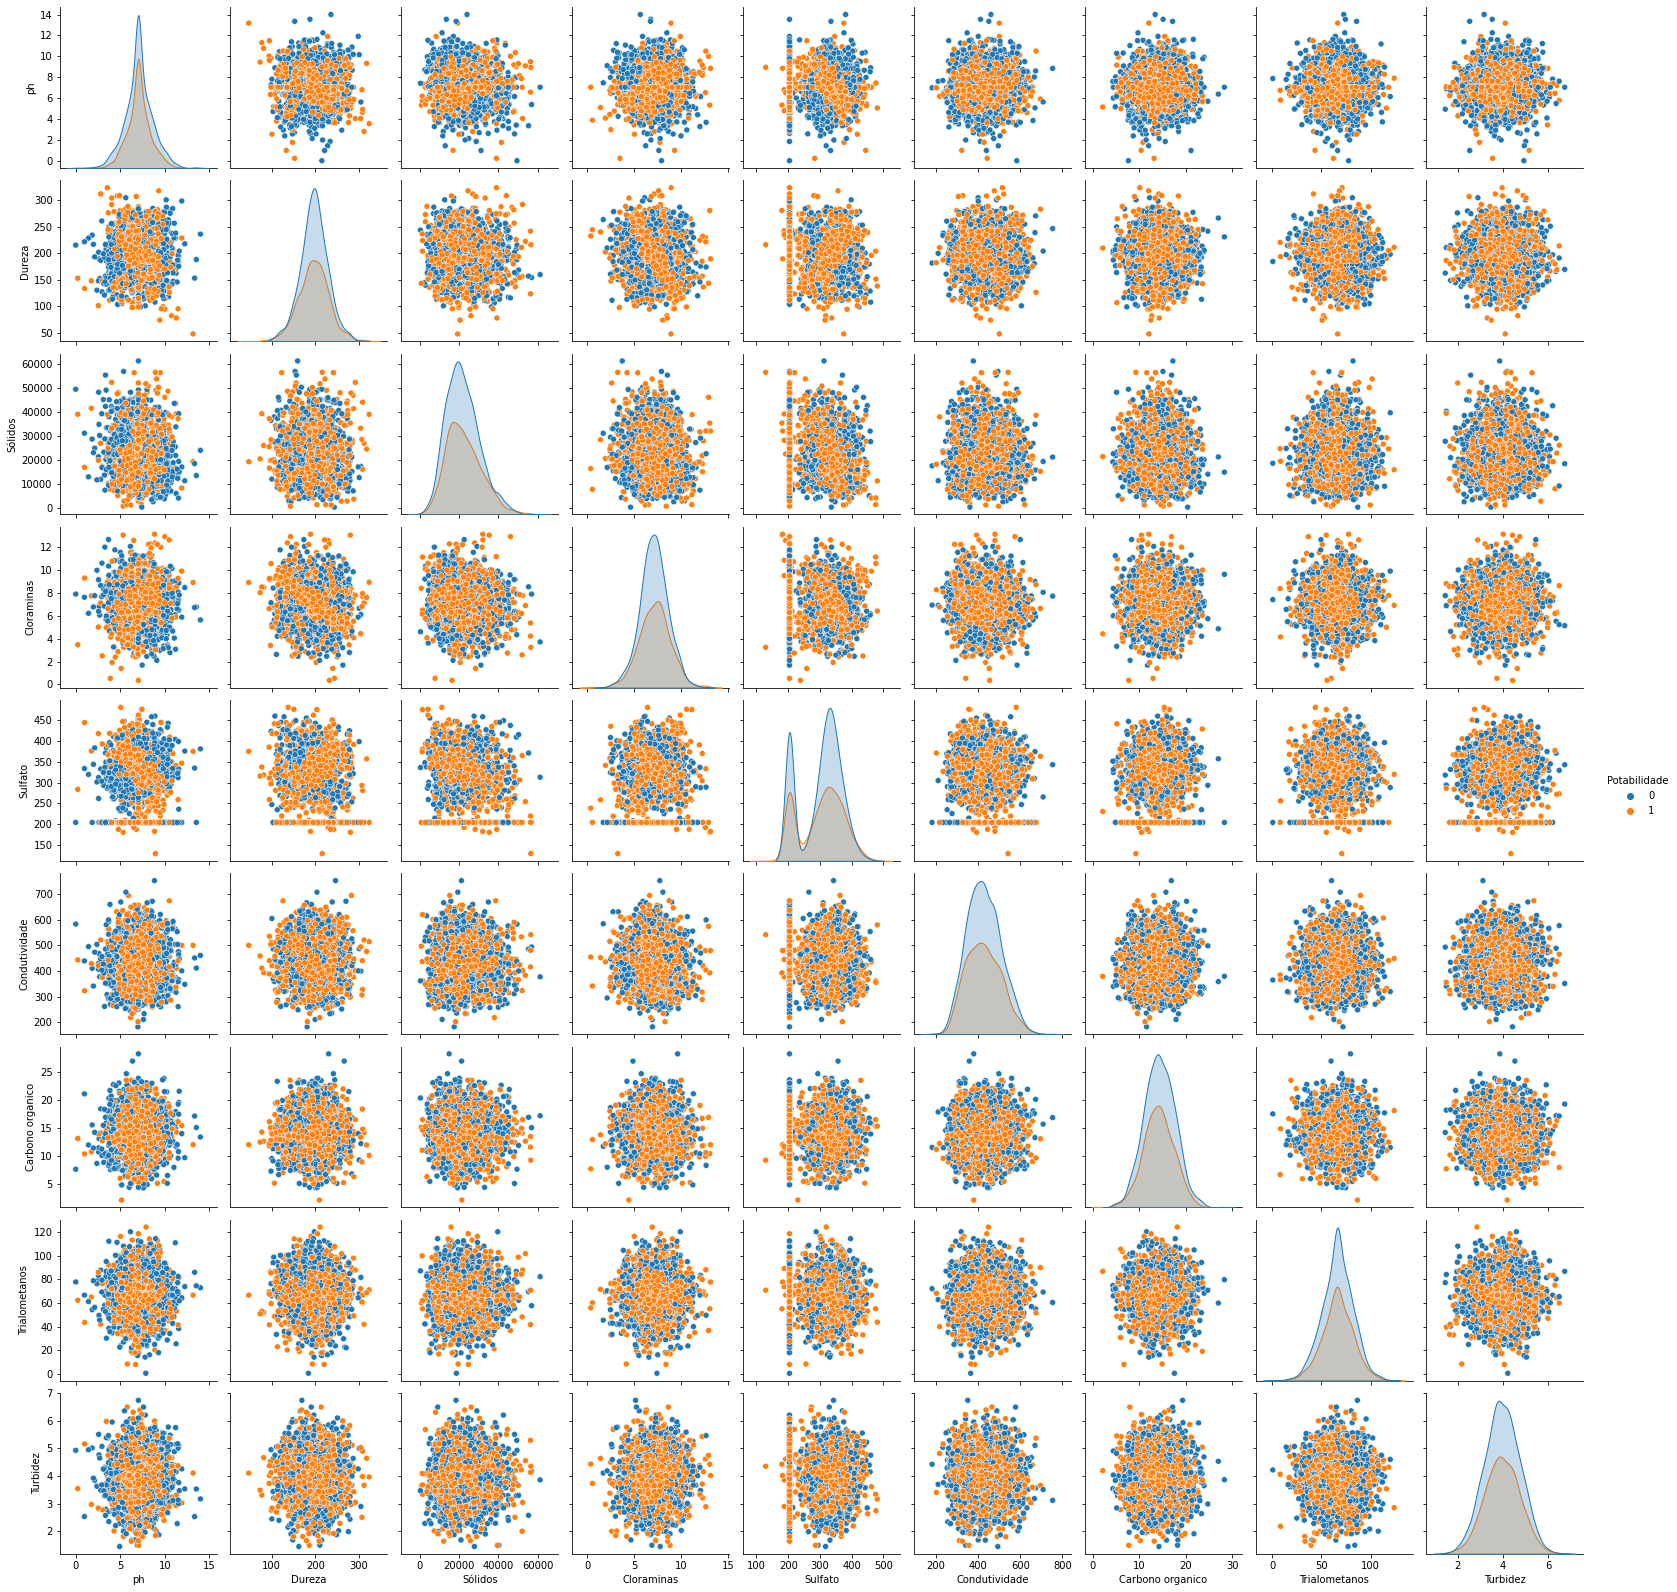

In [25]:
sns.pairplot(Data, hue ='Potabilidade')

<AxesSubplot:>

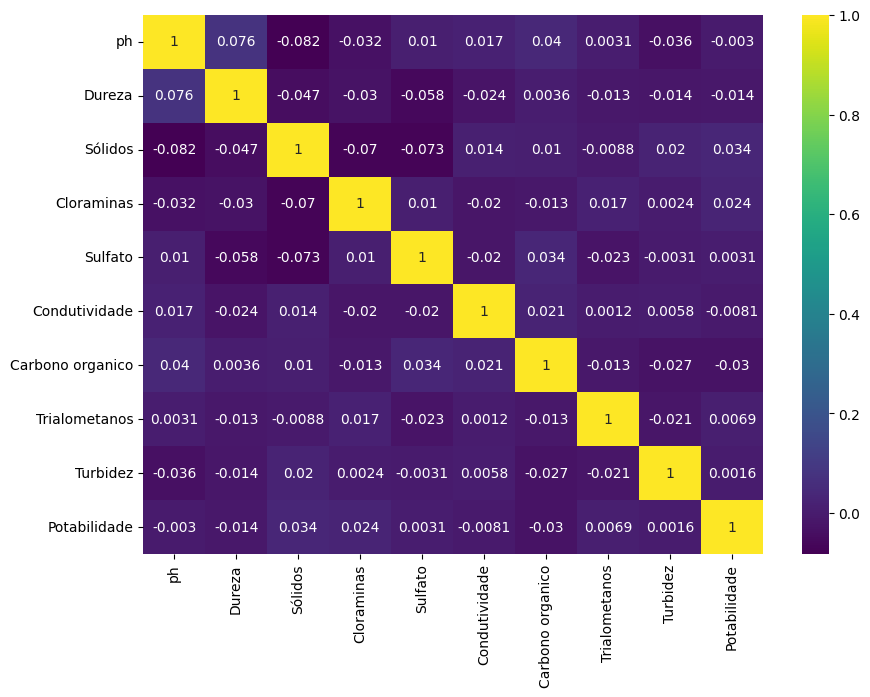

In [26]:
plt.figure(figsize=(10,7))
sns.heatmap(Data.corr(),annot=True,cmap='viridis')

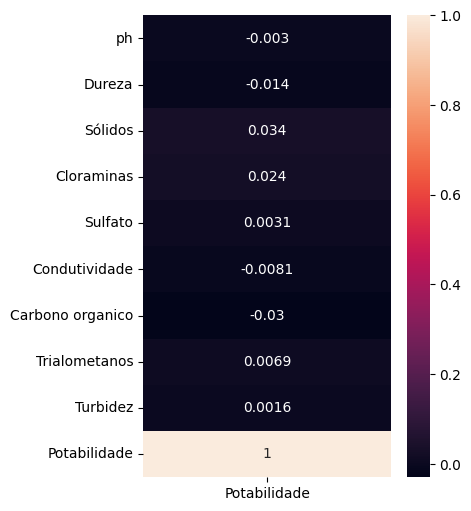

In [27]:
plt.figure(figsize = (4,6))
sns.heatmap(Data.corr()[['Potabilidade']], 
            annot = True
           );

### Aplicando os Modelos de Classificação

##### KNN (K Neighbors Classifier)

In [28]:
sc = StandardScaler()
# matriz de variáveis explicativas
X = Data.drop('Potabilidade', axis = 1)

# variável target
y = Data.Potabilidade


features = X.columns
X[features] = sc.fit_transform(X[features])
X.head()

,ph,Dureza,Sólidos,Cloraminas,Sulfato,Condutividade,Carbono organico,Trialometanos,Turbidez
0,-0.025474,0.259195,-0.139471,0.112415,0.994383,1.708954,-1.180651,1.305434,-1.286298
1,-2.284717,-2.036414,-0.385987,-0.307694,-1.495944,2.062575,0.270597,-0.639186,0.684218
2,0.697319,0.847665,-0.240047,1.360594,-1.495944,-0.094032,0.781117,0.000800,-1.167365
3,0.845393,0.547651,0.000493,0.592008,0.818253,-0.778830,1.255134,2.152154,0.848412
4,1.372982,-0.464429,-0.460249,-0.363698,0.110264,-0.343939,-0.824357,-2.182297,0.138786


In [29]:
# separa em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

print('Há', y_train.shape[0], 'dados de treino e', y_test.shape[0], 'dados de teste')

Há 2194 dados de treino e 1082 dados de teste


In [30]:
# instanciamos o modelo especificando o valor desejado de k com o argumento n_neighbors
knn = KNeighborsClassifier(n_neighbors = 19)

In [31]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [32]:
y_pred =  knn.predict(X_test)

In [33]:
# montamos uma tabela com as previsões, indicando se estavam corretas ou não
Data_pred = pd.concat([X_test, y_test, pd.Series(y_pred, index = y_test.index), 
                     y_test == y_pred], 
                    axis = 1
                   )

Data_pred.columns = ['ph', 'Dureza', 'Sólidos', 'Cloraminas', 'Sulfato', 'Condutividade',
                   'Carbono organico', 'Trialometanos', 'Turbidez', 'Potabilidade', 
                   'y_pred', 'pred_ok']
Data_pred.head()

,ph,Dureza,Sólidos,Cloraminas,Sulfato,Condutividade,Carbono organico,Trialometanos,Turbidez,Potabilidade,y_pred,pred_ok
2947,-0.025474,-0.390829,-0.177119,0.133264,0.458331,-0.864183,1.781944,0.038841,1.178894,0,0,True
2782,-0.293258,-0.226799,1.238672,-0.208970,0.469376,-1.109290,0.127534,0.091160,0.763090,1,0,False
1644,0.525144,0.842269,0.142578,-0.758072,-0.037134,-0.473122,-0.265515,-1.479766,-1.895280,0,0,True
70,0.058697,-0.403963,-1.741798,-2.097011,-0.382472,0.022660,-1.356049,1.498514,-0.104958,0,0,True
2045,-0.312178,-0.521033,0.499447,1.381617,-1.495944,0.868172,-0.453002,0.751854,0.623709,1,1,True


In [34]:
# obtemos a matriz de confusão
MCKNN = confusion_matrix(y_test, y_pred)
MCKNN

array([[580, 100],
       [296, 106]], dtype=int64)

In [35]:
round(accuracy_score(y_test, y_pred),2)

0.63

In [36]:
scores = cross_val_score(knn, X, y, cv = 10)
scores

array([0.62804878, 0.61280488, 0.62804878, 0.6402439 , 0.59756098,
       0.57621951, 0.56269113, 0.58409786, 0.59633028, 0.66360856])

<AxesSubplot:>

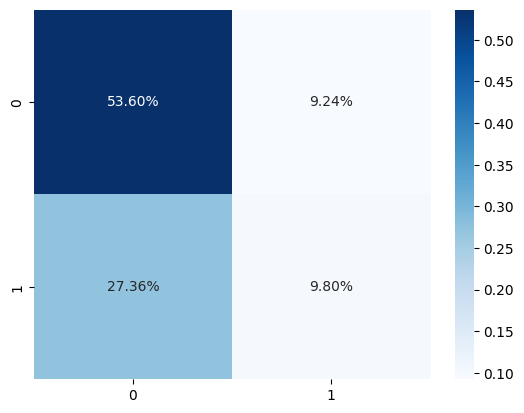

In [37]:
KNN_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(KNN_cm/np.sum(KNN_cm), annot = True, fmt = '0.2%', cmap = 'Blues')

In [38]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.85      0.75       680
           1       0.51      0.26      0.35       402

    accuracy                           0.63      1082
   macro avg       0.59      0.56      0.55      1082
weighted avg       0.61      0.63      0.60      1082



* precision: Porcentagem de previsões positivas corretas em relação ao total de previsões positivas
* recall: Porcentagem de previsões positivas corretas em relação ao total de positivos reais.
* f1-score: Uma média harmônica ponderada de precisão e recall. Quanto mais próximo de 1, melhor o modelo.

1. O Modelo previu que 51% das amostras de água são potáveis;
2. De todos as amostras de água que realmente era potável, o modelo só previu esse resultado corretamente para 26% deles;
3. F1-score = 0.35, como não é muito próximo de 1, isso nos diz que o modelo faz um trabalho ruim ao prever se a água é potável ou não;
4. 680 amostras de água não são potáveis e 402 são potáveis nos dados de teste.

##### Naive Bayes

In [39]:
# matriz de variáveis explicativas
X = Data.drop('Potabilidade', axis = 1)

# variável target
y = Data.Potabilidade

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2194, 9)
(1082, 9)
(2194,)
(1082,)


In [41]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [42]:
y_pred = gnb.predict(X_test)

In [43]:
round(accuracy_score(y_test, y_pred),2)

0.63

In [44]:
scores = cross_val_score(gnb, X, y, cv = 10)
scores

array([0.60365854, 0.57317073, 0.625     , 0.60365854, 0.64939024,
       0.52439024, 0.62079511, 0.60550459, 0.58409786, 0.64525994])

In [45]:
y_test.shape

(1082,)

In [46]:
y_pred.shape

(1082,)

In [47]:
conf_mat = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', conf_mat)

Confusion matrix

 [[632  48]
 [352  50]]


<AxesSubplot:>

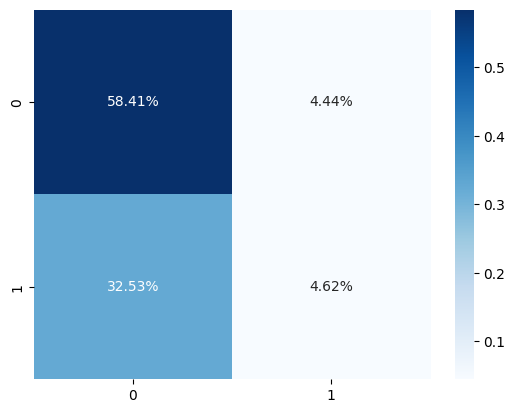

In [48]:
sns.heatmap(conf_mat/np.sum(conf_mat), annot = True, fmt = '0.2%', cmap = 'Blues')

In [49]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.93      0.76       680
           1       0.51      0.12      0.20       402

    accuracy                           0.63      1082
   macro avg       0.58      0.53      0.48      1082
weighted avg       0.59      0.63      0.55      1082



1. O Modelo previu que 51% das amostras de água são potáveis;
2. De todos as amostras de água que realmente era potável, o modelo só previu esse resultado corretamente para 12% deles;
3. F1-score = 0.2, como não é muito próximo de 1, isso nos diz que o modelo faz um trabalho ruim ao prever se a água é potável ou não;
4. 680 amostras de água não são potáveis e 402 são potáveis nos dados de teste.

##### Regressão Logística

In [50]:
# matriz de features
X = Data.drop(columns = ['Potabilidade'])


# variável target
y = Data['Potabilidade']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y, random_state = 0)

In [52]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [53]:
lr = LogisticRegression()
lr.fit(X_train_std, y_train)

LogisticRegression()

In [54]:
accuracy_score(y_train, lr.predict(X_train_std))

0.609845031905196

In [55]:
scores = cross_val_score(lr, X, y, cv = 10)
scores

array([0.6097561 , 0.6097561 , 0.6097561 , 0.6097561 , 0.6097561 ,
       0.6097561 , 0.6116208 , 0.6116208 , 0.60856269, 0.60856269])

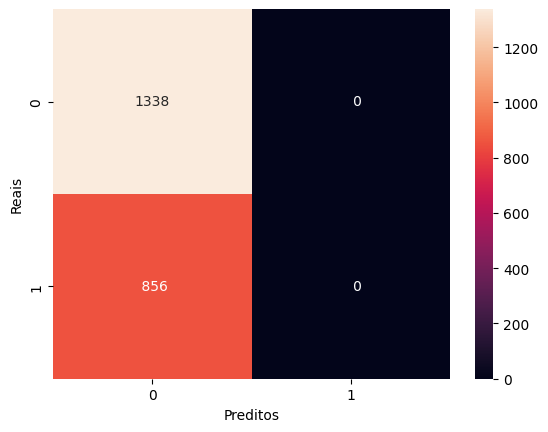

In [56]:
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.xlabel('Preditos')
plt.ylabel('Reais');

In [57]:
# verificamos que as proporções da variável target no treino e teste são correspondentes
y_train.mean(), y_test.mean()

(0.390154968094804, 0.3900184842883549)

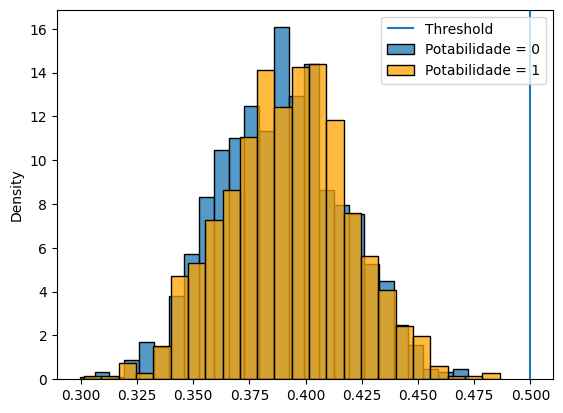

In [58]:
# Histograma de probabilidades
sns.histplot(data = lr.predict_proba(X_train_std[y_train == 0])[ : , 1], 
             stat = 'density'
            )

sns.histplot(data = lr.predict_proba(X_train_std[y_train == 1])[ : , 1], 
             stat = 'density', 
             color = 'orange'
            )
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Threshold', 'Potabilidade = 0', 'Potabilidade = 1']);

In [59]:
threshold = 0.45
probs = lr.predict_proba(X_train_std)[:,1]
y_pred = probs > threshold

In [60]:
accuracy_score(y_train, y_pred)

0.6107566089334548

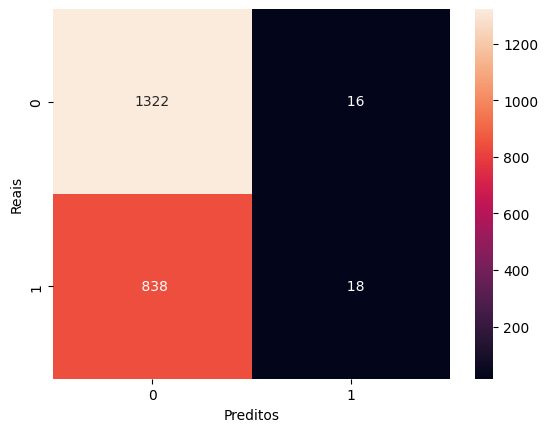

In [61]:
sns.heatmap(confusion_matrix(y_train, y_pred), 
            annot = True, 
            fmt = '4d'
           )

plt.xlabel('Preditos')
plt.ylabel('Reais');

In [62]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.99      0.76      1338
           1       0.53      0.02      0.04       856

    accuracy                           0.61      2194
   macro avg       0.57      0.50      0.40      2194
weighted avg       0.58      0.61      0.48      2194



1. O Modelo previu que 53% das amostras de água são potáveis;
2. De todos as amostras de água que realmente era potável, o modelo só previu esse resultado corretamente para 2% deles;
3. F1-score = 0.04, como não é muito próximo de 1, isso nos diz que o modelo faz um trabalho ruim ao prever se a água é potável ou não;
4. 1338 amostras de água não são potáveis e 856 são potáveis nos dados de teste.

##### Árvore de Decisão (Decision Tree)

In [63]:
# matriz de features
X = Data.drop(columns = ['Potabilidade'])


# variável target
y = Data['Potabilidade']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [65]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [66]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_std,y_train)

DecisionTreeClassifier()

In [67]:
y_pred = dtree.predict(X_test_std)

In [68]:
round(accuracy_score(y_test, y_pred),2)

0.57

In [69]:
scores = cross_val_score(dtree, X, y, cv = 10)
scores

array([0.56402439, 0.52743902, 0.59146341, 0.5945122 , 0.61585366,
       0.57012195, 0.5351682 , 0.56269113, 0.57186544, 0.57798165])

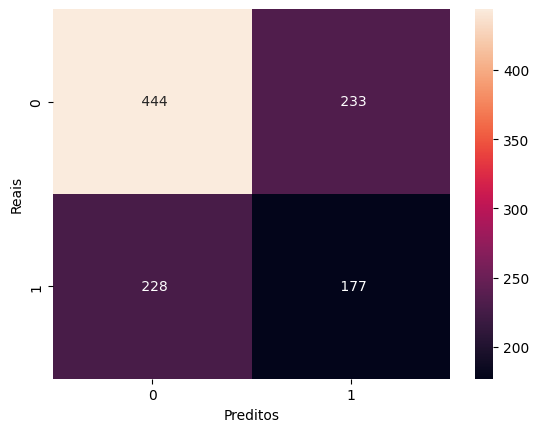

In [70]:
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot = True, 
            fmt = '4d'
           )

plt.xlabel('Preditos')
plt.ylabel('Reais');

<AxesSubplot:>

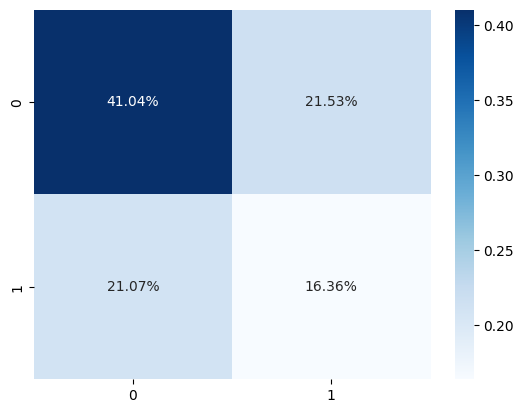

In [71]:
KNN_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(KNN_cm/np.sum(KNN_cm), annot = True, fmt = '0.2%', cmap = 'Blues')

In [72]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       677
           1       0.43      0.44      0.43       405

    accuracy                           0.57      1082
   macro avg       0.55      0.55      0.55      1082
weighted avg       0.57      0.57      0.57      1082



1. O Modelo previu que 44% das amostras de água são potáveis;
2. De todos as amostras de água que realmente era potável, o modelo só previu esse resultado corretamente para 45% deles;
3. F1-score = 0.45, como não é muito próximo de 1, isso nos diz que o modelo faz um trabalho ruim ao prever se a água é potável ou não;
4. 677 amostras de água não são potáveis e 405 são potáveis nos dados de teste.

##### AdaBoost

In [73]:
# matriz de features
X = Data.drop(columns = ['Potabilidade'])


# variável target
y = Data['Potabilidade']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

In [75]:
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)

In [76]:
model = abc.fit(X_train, y_train)

In [77]:
y_pred = model.predict(X_test)

In [78]:
round(accuracy_score(y_test, y_pred),2)

0.61

In [79]:
scores = cross_val_score(abc, X, y, cv = 10)
scores

array([0.63414634, 0.60060976, 0.625     , 0.60670732, 0.64329268,
       0.50304878, 0.52905199, 0.59938838, 0.59938838, 0.60550459])

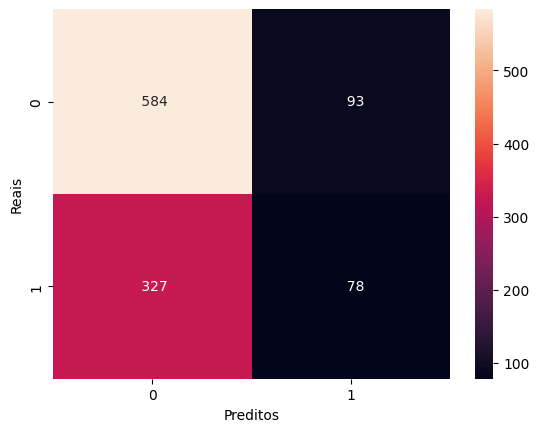

In [80]:
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot = True, 
            fmt = '4d'
           )

plt.xlabel('Preditos')
plt.ylabel('Reais');

<AxesSubplot:>

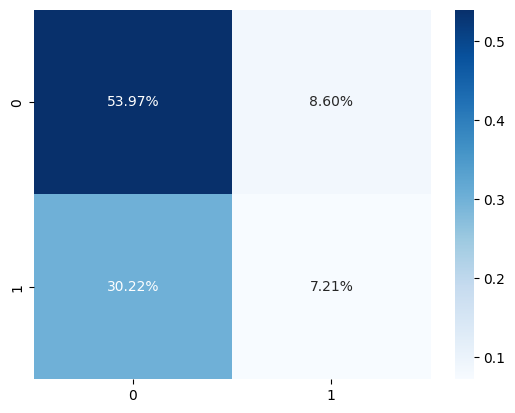

In [81]:
abc_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(abc_cm/np.sum(KNN_cm), annot = True, fmt = '0.2%', cmap = 'Blues')

In [82]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.86      0.74       677
           1       0.46      0.19      0.27       405

    accuracy                           0.61      1082
   macro avg       0.55      0.53      0.50      1082
weighted avg       0.57      0.61      0.56      1082



1. O Modelo previu que 46% das amostras de água são potáveis;
2. De todos as amostras de água que realmente era potável, o modelo só previu esse resultado corretamente para 19% deles;
3. F1-score = 0.27, como não é muito próximo de 1, isso nos diz que o modelo faz um trabalho ruim ao prever se a água é potável ou não;
4. 677 amostras de água não são potáveis e 405 são potáveis nos dados de teste.

### Comparando os Modelos

In [85]:
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
mod = []
cv_score=[]
acc_score = []
model =[KNeighborsClassifier(), GaussianNB(), LogisticRegression(), DecisionTreeClassifier(), AdaBoostClassifier()]
for m in model:
    m.fit(X_train,y_train)
    cv_score.append(cross_val_score(m, X_train, y_train, scoring='accuracy', cv=11).mean())
    y_pred = m.predict(X_test)
    acc_score.append(accuracy_score(y_test,y_pred).mean())
    mod.append(m)
model_df=pd.DataFrame(columns=['model','cross_validation_score','accuracy_score'])
model_df['model']=mod
model_df['cross_validation_score']=cv_score
model_df['accuracy_score']=acc_score
model_df.sort_values(by=['accuracy_score'], ascending=True).style.background_gradient(subset=['accuracy_score'])

,model,cross_validation_score,accuracy_score
0,KNeighborsClassifier(),0.531021,0.542514
3,DecisionTreeClassifier(),0.562887,0.578558
4,AdaBoostClassifier(),0.589767,0.611830
2,LogisticRegression(),0.600731,0.622921
1,GaussianNB(),0.597076,0.630314


* Com todas as especificações dos modelos, além da cross validation, accuracy score, também temos: precision, recall, f1-score. Dito isso, o melhor modelo a ser usado é a Árvore de Decisão. O cross validation e o accuracy score são um pouco pior que o dos outros, porém o precision, recall e a f1- score são muito melhores que dos outros.